In [1]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
from tensorflow import keras
import numpy as np
import random
import os
import gc
import time
import platform

from matplotlib import pyplot as plt

In [3]:
BASE_DIR = ""
NUM_CLASSES=10
WIDTH = 28
NUM_CHANNELS = 1

def _normalize(X):
  assert X.dtype == np.uint8
  X = X.astype(np.float64)
  X /= 255
  return X

def load_standard_mnist():
  (X_train, Y_train), (X_validation, Y_validation) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
  X_train = X_train.reshape(X_train.shape[0], WIDTH, WIDTH, 1)
  X_validation = X_validation.reshape(X_validation.shape[0], WIDTH, WIDTH, 1)

  X_train = _normalize(X_train)
  X_validation = _normalize(X_validation)

  Y_train = Y_train.astype(np.int32)
  Y_validation = Y_validation.astype(np.int32)

  return X_train, Y_train, X_validation, Y_validation

def load_mnist_train_dev():
  # these were randomly picked, then fixed for future
  selected_dev = [8106, 9910, 3397, 8870, 2103, 5689, 9799, 4037, 1584, 1160, 9063,
       1332, 3043, 8307, 1042, 3466, 7772, 7327, 7098, 7216, 8624, 6400,
       5811, 1862, 7327, 1626, 5958, 3868, 3795,  836, 3406, 5570, 9535,
       9653, 7890, 5671, 2451, 9175, 8310, 2425, 5923, 2797, 1150, 6012,
       8666, 8849, 6839, 5994, 6751, 9139, 9648, 8898, 9869, 2184, 1363,
       8294, 4000, 5424, 4544,  330, 4325, 4597, 4735, 9966, 2342, 7220,
       5774, 3437, 4276,  760, 7868, 2993, 6262, 8880, 6017, 5045, 9513,
       4084, 7115, 5775,  358, 3549, 2612, 8973, 6747,  415, 8573, 9973,
       2734,  586, 3937, 6889, 1191, 5255, 1460,  413, 7257, 5272, 7402,
       7968]
  X_train, Y_train, X_validation, Y_validation = load_standard_mnist()
  X_dev = X_validation[selected_dev]
  Y_dev = Y_validation[selected_dev]
  return X_train, Y_train, X_dev, Y_dev

In [4]:
X_train, Y_train, X_dev, Y_dev = load_mnist_train_dev()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
pred_infl = np.load(BASE_DIR + '/pred_infl.npy', allow_pickle=True)
penult_infl = np.load(BASE_DIR + '/penult_infl.npy', allow_pickle=True)

In [7]:
TRIAL = 1
trackin_influences = np.zeros((100, 60000))
for ckpt_num in [4, 14, 29, 44, 59, 74]:
  trackin_influences += np.load(BASE_DIR + '/tmp/mnist/original/{0}/trackin_loss_infl_{1}.npz'.format(TRIAL, ckpt_num+1))['arr_0']

In [8]:
representer_infl = np.load(BASE_DIR + '/tmp/mnist/original/{0}/dev_representer_infl.npz'.format(TRIAL))['arr_0']
representer_infl.shape

(100, 60000)

In [9]:
infl_fns = np.transpose(np.load(BASE_DIR + '/tmp/mnist/original/{0}/dev_influences_inf_fun.npz'.format(TRIAL))['arr_0'])

In [11]:
def plot_test_image(i, img, true_label, predictions_array):
  true_label, img = true_label[i], img[i].reshape(WIDTH, WIDTH)
  predicted_label = predictions_array[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.box(on=None)

  plt.imshow(img, cmap=plt.cm.binary)

  if predicted_label == true_label:
    color = 'tab:blue'
  else:
    color = 'tab:red'
  
  plt.title("{0} ({1})".format(true_label, predicted_label),
                                color=color, fontsize=13)


def plot_influence_image(i, img, true_label, influence, predicted_label):
  img = img.reshape(WIDTH, WIDTH)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.box(on=None)

  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == true_label:
    color = 'tab:blue'
  else:
    color = 'tab:red'
  plt.title("{0} ({1})".format(true_label, predicted_label),
                                color=color, fontsize=13)


def compare_methods(ex_id, X_train, Y_train, P_train, X_dev, Y_dev, P_dev, inf_list, names_list,
                    num_pos=5, num_neg=5, space_pos_neg=2, save_name=None):
    
  num_cols = 1+3+num_pos+space_pos_neg+num_neg 
  num_train_examples = X_train.shape[0]
  num_rows = len(inf_list) + 1
  plt.figure(figsize=(num_cols, 1.3*num_rows))
  plt.subplot(num_rows, num_cols, 3*(num_cols)+1)  # position as per number of methods
  plot_test_image(ex_id, X_dev, Y_dev, P_dev)
  i = 1
  for (name, influences) in zip(names_list, inf_list):
    inf_values = rankings = np.flip(np.sort(influences[ex_id]))
    rankings = np.flip(np.argsort(influences[ex_id]))
    ax = plt.subplot(num_rows, num_cols, (num_cols)*i+3, xlabel=name)
    # ax.set_title(name)
    ax.set_title(name, x=1, y=0.3)  # aligning method with images
    ax.set_axis_off()
  
    # print(name)
    print(inf_values[:num_pos])
    for j in range(0,num_pos): # 5 most positive influential examples
      plt.subplot(num_rows, num_cols, (num_cols)*i+2+2+(j+1))
      influence_ex_id = rankings[j]
      plot_influence_image(influence_ex_id, X_train[influence_ex_id], Y_train[influence_ex_id], influences[i][influence_ex_id], P_train[influence_ex_id])
    if num_neg > 0:
      print(inf_values[-num_neg:], '\n')
    ### conditional selection for least similar in same and pred (code from hyp in HOP)
    is_dist_based = ('same' in name.lower()) or ('baseline' in name.lower()) or ('emb' in name.lower())
    if is_dist_based:
      similarity = -1*influences[ex_id]
      y_pred = P_dev[ex_id]
      same_class = (Y_train==y_pred)
      similarity_cond = similarity[same_class]
      # Note that lowest distance means most similar
      most_similar_cond = np.sort(similarity_cond)
      least_similar_cond = most_similar_cond[::-1]
    ###
    for j in range(0,num_neg): # 5 most negative influential examples
      plt.subplot(num_rows, num_cols, (num_cols)*i+2+2+num_neg+1+(j+space_pos_neg))
      if is_dist_based:
        influence_ex_id = np.argmax(similarity == least_similar_cond[j])
      else:
        # so there opponent is really least ranked point (which is why they don't need to explicitly condition; we can suggest such explicit conditioning as well!)
        influence_ex_id = rankings[num_train_examples-(num_neg-j)]
      plot_influence_image(influence_ex_id, X_train[influence_ex_id], Y_train[influence_ex_id], influences[i][influence_ex_id], P_train[influence_ex_id])
    i += 1

  if save_name:
    plt.savefig(save_name, dpi=300, format='pdf', bbox_inches='tight', pad_inches=0)
  plt.show()

In [12]:
model = keras.models.load_model(BASE_DIR + '/tmp/mnist/original/{0}/model_ckpt_75.h5'.format(TRIAL))

P_train = np.argmax(model.predict(np.squeeze(X_train)), axis=1)
P_dev = np.argmax(model.predict(np.squeeze(X_dev)), axis=1)

4/4 [==============================] - 0s 6ms/step


In [13]:
# %matplotlib notebook
import matplotlib
matplotlib.rcParams["figure.dpi"] = 100

10
[-6.28030539e-07 -1.18245248e-06 -1.23503898e-06 -1.52078664e-06
 -1.54308715e-06]
[-1.4141957 -1.4141957 -1.4141957 -1.4141957 -1.4141957] 

[-2.74766323 -3.77077434 -3.7770595  -4.10012274 -4.16789671]
[-31.90007324 -31.90848836 -32.15739403 -32.5865999  -32.67894618] 

[62.38911748 62.3044229  60.65576433 56.17088037 53.19033859]
[-44.93652992 -45.93863854 -48.7963015  -50.14000668 -52.52093755] 

[695.885   651.24524 609.8701  599.5892  554.18146]
[-466.63046 -492.1606  -513.77856 -525.36914 -616.6023 ] 

[5.2786584 4.2787843 3.7138867 3.6925535 3.3973062]
[-3.1936834 -3.3884122 -3.792415  -3.9458578 -4.166173 ] 



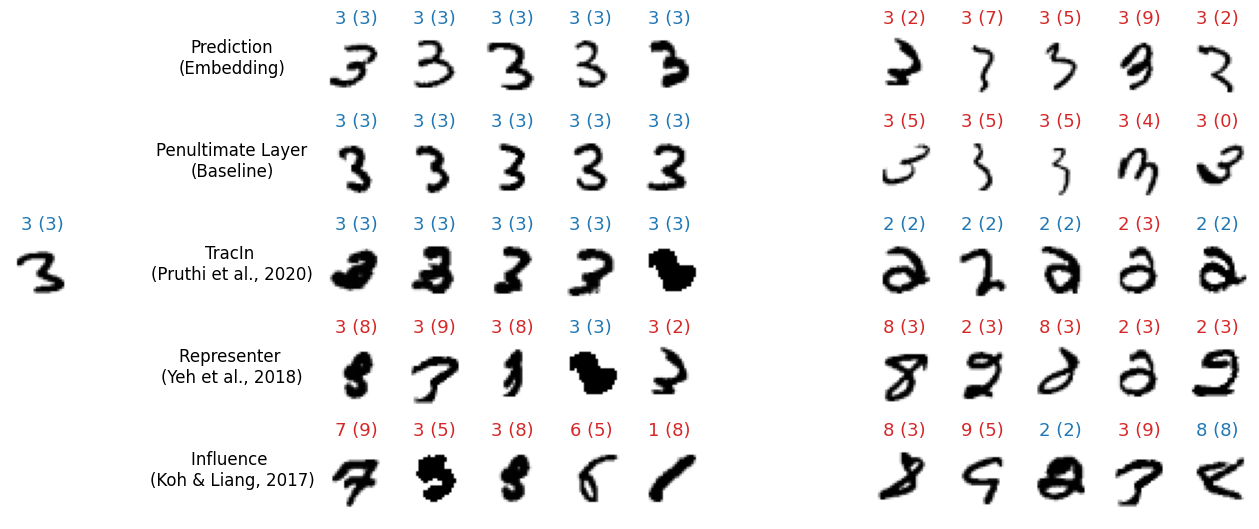

69
[-0.00581303 -0.00959303 -0.01298589 -0.01467803 -0.02229064]
[-1.24622219 -1.24622219 -1.24622219 -1.24622219 -1.24622219] 

[-2.56279656 -2.57475212 -2.92596642 -2.95520442 -2.9695505 ]
[-32.94276146 -33.34906521 -33.91480373 -34.01384159 -34.2581854 ] 

[39914.29074083 39003.69966741 33517.94670995 31644.5703426
 30047.70546072]
[-26452.30754168 -28879.06595684 -29943.20944721 -33434.26672072
 -40025.48324358] 

[354.59915 315.9426  297.80493 297.2295  294.15277]
[-221.96301 -222.68831 -237.38686 -252.81638 -268.16797] 

[823.77094 745.9568  632.4788  632.1314  561.83124]
[-471.2008  -487.75836 -543.6843  -552.242   -663.9887 ] 



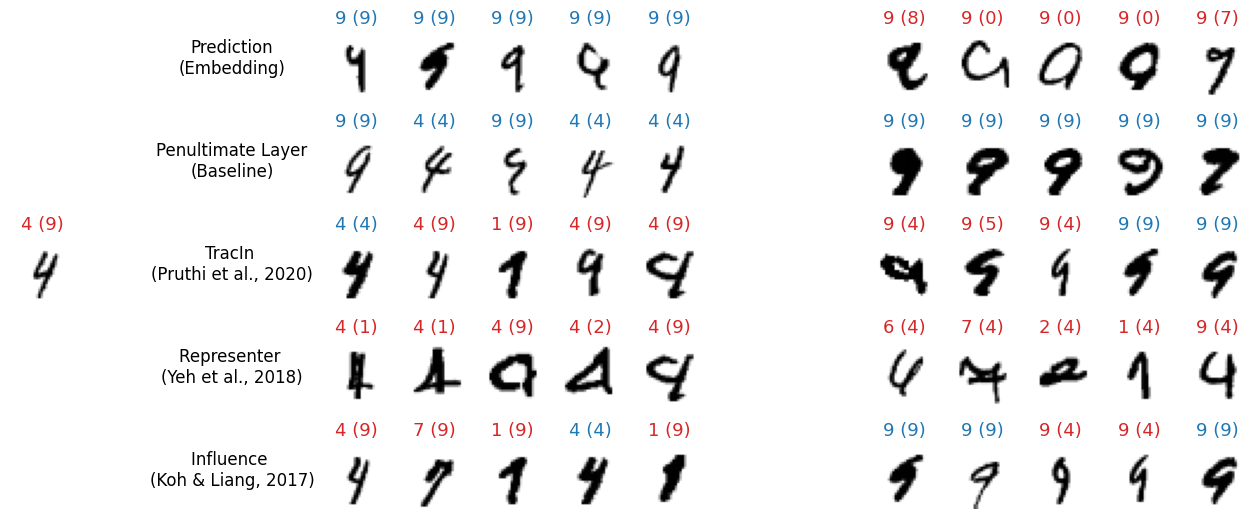

In [16]:
n_dev = len(Y_dev)
for ex_id in [10, 69]:
# for ex_id in np.random.choice(n_dev, int(1*n_dev), replace=False):
  # compare_methods(ex_id, X_train, Y_train, P_train, X_dev, Y_dev, P_dev, trackin_influences, representer_infl, infl_fns)
  print(ex_id)
  compare_methods(ex_id, X_train, Y_train, P_train, X_dev, Y_dev, P_dev, 
                  [pred_infl, penult_infl, trackin_influences, representer_infl, infl_fns], 
                  ['Prediction\n(Embedding)', 'Penultimate Layer\n(Baseline)', 'TracIn \n(Pruthi et al., 2020)', 'Representer \n(Yeh et al., 2018)', 'Influence \n(Koh & Liang, 2017)'], 
                  num_pos=5, num_neg=5, save_name=f"{BASE_DIR}/sota_mnist_{ex_id}_msls")

In [ ]:
print('Training Acc:', (P_train==Y_train).mean())
print('Dev Acc:', (P_dev==Y_dev).mean())

Training Acc: 0.9932
Dev Acc: 0.97
